In [1]:
import numpy as np
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import cv2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-04-03 15:37:55.001258: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 15:37:55.031707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 15:37:55.425182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-04-03 15:37:56.101202: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


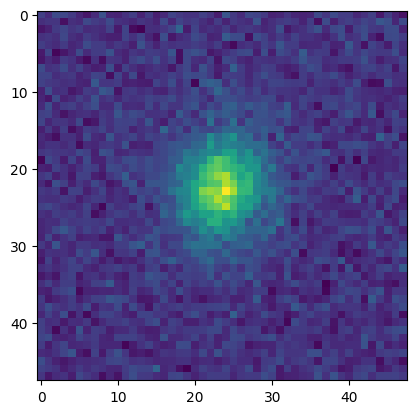

In [4]:
im = cv2.imread("galaxy_postage/training/mdm_galaxy_training_1.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(im)

In [5]:
import pandas as pd
sol = pd.read_csv("mdm_training_solution_sorted.csv")
e1s = sol['e1'].to_numpy()
e2s = sol['e2'].to_numpy()

In [36]:
# to make it positive
mod_e1_val = np.abs(e1s.min())
me1s = e1s + mod_e1_val
mod_e2_val = np.abs(e2s.min())
me2s = e2s + mod_e2_val

train_mes = np.column_stack((me1s,me2s))

train_es = np.column_stack((e1s,e2s))

train_es.shape

(40000, 2)

In [7]:
tsol = pd.read_csv("mdm_solution.csv")
te1s = tsol['e1_solution'].to_numpy()
te2s = tsol[' e2_solution'].to_numpy()

In [37]:
mod_te1_val = np.abs(te1s.min())
mte1s = te1s + mod_te1_val
mod_te2_val = np.abs(te2s.min())
mte2s = te2s + mod_te2_val

test_mes = np.column_stack((mte1s,mte2s))

test_es = np.column_stack((te1s,te2s))

test_es.shape

(60000, 2)

###### error type

In [18]:
def abserr(value, truth):
    return np.abs(value - truth)

def sqerr(value, truth):
    return (value - truth) * (value - truth)

## UWQM

In [8]:
def getUWQM(image):
    pixel_len = np.linspace(1, image.shape[0], image.shape[0])

    x, y = np.meshgrid(pixel_len, pixel_len)

    sum_pix = np.sum(image)
    im_meanx = np.sum(image * x) / sum_pix
    im_meany = np.sum(image * y) / sum_pix

    q11 = np.sum(image * (x - im_meanx) * (x - im_meanx)) / sum_pix
    q12 = np.sum(image * (x - im_meanx) * (y - im_meany)) / sum_pix
    q22 = np.sum(image * (y - im_meany) * (y - im_meany)) / sum_pix

    e1 = (q11-q22)/(q11+q22)
    e2 = 2*q12/(q11+q22)
    return e1, e2

print(getUWQM(im))

(-0.0031841092975681746, -0.0025858177224442067)


In [5]:
import pandas as pd
sol = pd.read_csv("mdm_training_solution_sorted.csv")
e1s = sol['e1'].to_numpy()
e2s = sol['e2'].to_numpy()

mse_e1 = 0
mse_e2 = 0

for i in range(1, 40001):
    image_path = f"galaxy_postage/training/mdm_galaxy_training_{i}.png"
    im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # im = ndi.gaussian_filter(im, sigma=0.5) # denoise
    es = getUWQM(im)
    mse_e1 += abserr(e1s[i-1], es[0])
    mse_e2 += abserr(e2s[i-1], es[1])
    if i % 10 == 0:
        print(f"{i} done!",end="\r")
    
mse_e1 /= e1s.shape[0]
mse_e2 /= e2s.shape[0]

mse_e1 = np.sqrt(mse_e1)
mse_e2 = np.sqrt(mse_e2)

print()
print(mse_e1)
print(mse_e2)

40000 done!
0.3536182642378644
0.3411426191762423


## Trying a new way

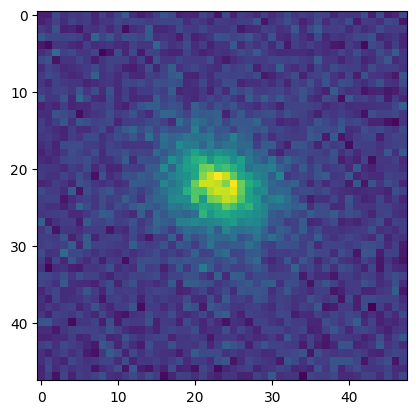

In [6]:
im = cv2.imread("galaxy_postage/training/mdm_galaxy_training_3.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(im)

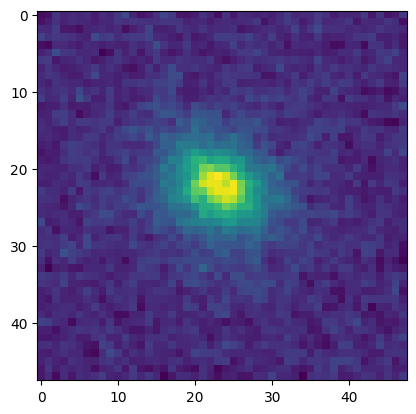

In [7]:
denoised_im = ndi.gaussian_filter(im, sigma=0.5)
plt.imshow(denoised_im)

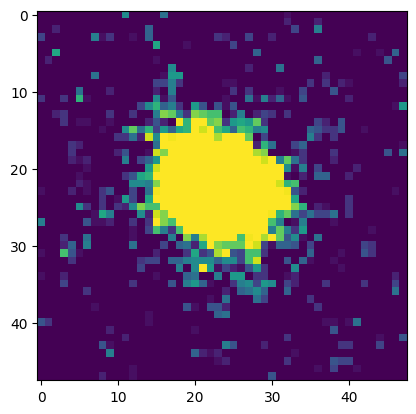

In [8]:
normalized_im = ((denoised_im - denoised_im.mean()) / denoised_im.std()).clip(0, 1)
plt.imshow(normalized_im)

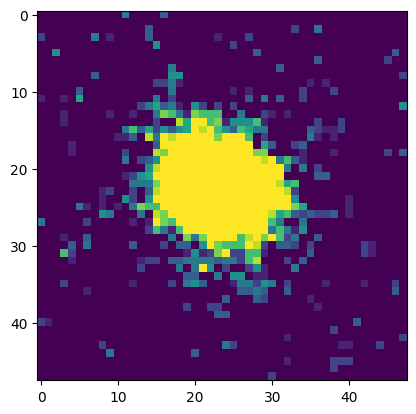

In [9]:
red_bit_depth = (normalized_im * 10).astype(np.int8) / 10
plt.imshow(red_bit_depth)

In [10]:
from bresenham import bresenham

pointset_bound = np.array([
    [0, 24], [6.431, 24], [13.856, 24], [24, 24], [24, 13.856], [24, 6.431],
    [24, 0], [24, -6.431], [24, -13.856], [24, -24], [13.856, -24], [6.431, -24]
])
pointset_bound = pointset_bound.round().astype(np.int_)

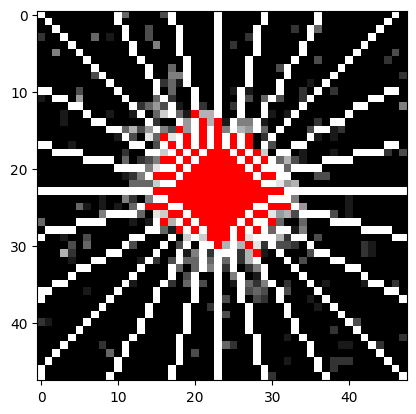

In [11]:
debug_color_img = np.dstack([red_bit_depth, red_bit_depth, red_bit_depth])

for point in pointset_bound:
    other_point = -point
    mpoint = point + 23
    other_mpoint = other_point + 23
    point_arr = np.array(list(bresenham(mpoint[0], mpoint[1], other_mpoint[0], other_mpoint[1]))).clip(0,47)[:-1]
    line_intensities = np.zeros(48)
    for idx, pos in enumerate(point_arr):
        line_intensities[idx] = red_bit_depth[pos[0]][pos[1]]
    # print(line_intensities)
    line_intensities = np.convolve([1, 1, 1], line_intensities, mode='same') # smoothening
    line_intensities = line_intensities > (line_intensities.mean() + 0.7*line_intensities.std())
    for idx, pos in enumerate(point_arr):
        if line_intensities[idx]:
            debug_color_img[pos[0], pos[1], :] = [1, 0, 0]
        else:
            debug_color_img[pos[0], pos[1], :] = [1, 1, 1]

plt.imshow(debug_color_img)

extracting the features

In [12]:
# feature extraction
def getfeatures(image):
    features = np.zeros(pointset_bound.shape[0]).astype(np.float16)
    for fi, point in enumerate(pointset_bound):
        other_point = -point
        mpoint = point + 23
        other_mpoint = other_point + 23
        point_arr = np.array(list(bresenham(mpoint[0], mpoint[1], other_mpoint[0], other_mpoint[1]))).clip(0,47)[:-1]
        line_intensities = np.zeros(48)
        for idx, pos in enumerate(point_arr):
            line_intensities[idx] = image[pos[0]][pos[1]]
        # print(line_intensities)
        line_intensities = np.convolve([1, 1, 1], line_intensities, mode='same') # smoothening
        line_intensities = line_intensities > (line_intensities.mean() + 0.7*line_intensities.std())
        features[fi] = np.sum(line_intensities) / line_intensities.shape[0]
    return features

In [13]:
getfeatures(im)

array([0.2291, 0.1875, 0.2291, 0.1875, 0.1875, 0.1875, 0.1875, 0.2084,
       0.1875, 0.1666, 0.1666, 0.2084], dtype=float16)

In [14]:
galaxy_extracted_features = np.zeros((40000, pointset_bound.shape[0])).astype(np.float32)
star_extracted_features = np.zeros((40000, pointset_bound.shape[0])).astype(np.float32)
star_images = np.zeros((40000, 48, 48, 1)).astype(np.float32)
galaxy_images = np.zeros((40000, 48, 48, 1)).astype(np.float32)

test_galaxy_extracted_features = np.zeros((60000, pointset_bound.shape[0])).astype(np.float32)
test_star_extracted_features = np.zeros((60000, pointset_bound.shape[0])).astype(np.float32)
test_star_images = np.zeros((60000, 48, 48, 1)).astype(np.float32)
test_galaxy_images = np.zeros((60000, 48, 48, 1)).astype(np.float32)

# getting images
for i in range(1, 40001):
    image_path = f"star_postage/training/mdm_star_training_{i}.png"
    im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    star_images[i-1] = im.reshape((48, 48, 1)) / 255
    im = ndi.gaussian_filter(im, sigma=0.5)
    im = ((im - im.mean()) / im.std()).clip(0, 1)
    # im = (im * 10).astype(np.int8) / 10
    star_extracted_features[i-1] = getfeatures(im)
    image_path = f"galaxy_postage/training/mdm_galaxy_training_{i}.png"
    im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    galaxy_images[i-1] = im.reshape((48, 48, 1)) / 255
    im = ndi.gaussian_filter(im, sigma=0.5)
    im = ((im - im.mean()) / im.std()).clip(0, 1)
    # im = (im * 10).astype(np.int8) / 10
    galaxy_extracted_features[i-1] = getfeatures(im)
    if i % 10 == 0:
        print(f"{i} training loaded!",end="\r")


print()


# getting images
for i in range(1, 60001):
    image_path = f"star_postage/test/mdm_star_test_{i}.png"
    im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    test_star_images[i-1] = im.reshape((48, 48, 1)) / 255
    im = ndi.gaussian_filter(im, sigma=0.5)
    im = ((im - im.mean()) / im.std()).clip(0, 1)
    # im = (im * 10).astype(np.int8) / 10
    test_star_extracted_features[i-1] = getfeatures(im)
    image_path = f"galaxy_postage/test/mdm_galaxy_test_{i}.png"
    im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    test_galaxy_images[i-1] = im.reshape((48, 48, 1)) / 255
    im = ndi.gaussian_filter(im, sigma=0.5)
    im = ((im - im.mean()) / im.std()).clip(0, 1)
    # im = (im * 10).astype(np.int8) / 10
    test_galaxy_extracted_features[i-1] = getfeatures(im)
    if i % 10 == 0:
        print(f"{i} testing loaded!",end="\r")




# # getting test images
# for i in range(1, 60001):
#     image_path = f"star_postage/test/mdm_star_test_{i}.png"
#     im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     test_star_images[i-1] = im.reshape((48, 48, 1)) / 255
#     image_path = f"galaxy_postage/test/mdm_galaxy_test_{i}.png"
#     im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     im = ndi.gaussian_filter(im, sigma=0.5)
#     im = ((im - im.mean()) / im.std()).clip(0, 1)
#     # im = (im * 10).astype(np.int8) / 10
#     test_galaxy_extracted_features[i-1] = getfeatures(im)
#     if i % 10 == 0:
#         print(f"{i} test loaded!",end="\r")
    
print("\nAll Star images and features Loaded.")

40000 training loaded!
60000 testing loaded!
All Star images and features Loaded.


[0.22912598 0.20837402 0.22912598 0.1875     0.1875     0.20837402
 0.25       0.20837402 0.20837402 0.14587402 0.1875     0.25      ]
[0.3125     0.33325195 0.29174805 0.27075195 0.3125     0.33325195
 0.33325195 0.39575195 0.33325195 0.22912598 0.29174805 0.29174805]
max star: 0.7803921699523926 || min star: 0.125490203499794
max galaxy: 0.9215686321258545 || min galaxy: 0.2549019753932953


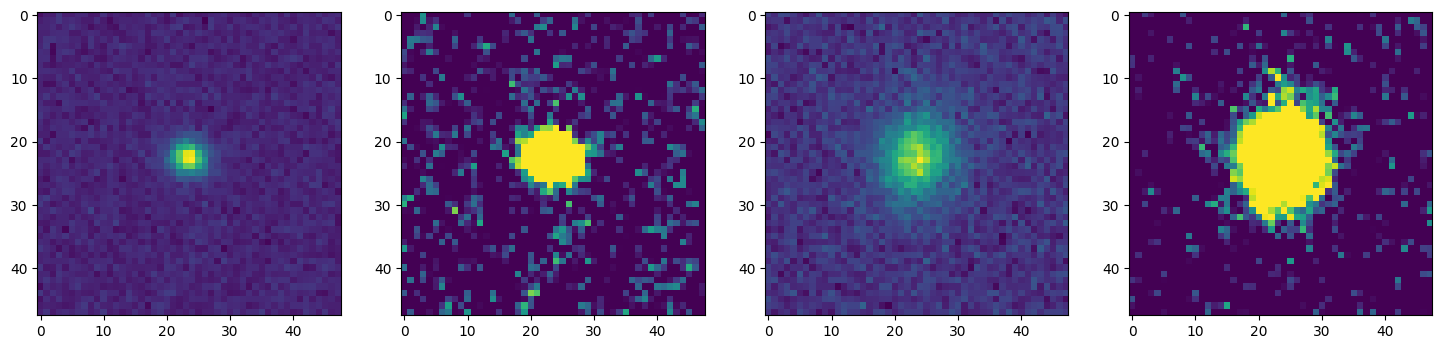

In [79]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
print(star_extracted_features[0])
print(galaxy_extracted_features[0])
print(f"max star: {star_images[0].max()} || min star: {star_images[0].min()}")
print(f"max galaxy: {galaxy_images[0].max()} || min galaxy: {galaxy_images[0].min()}")
axes[0].imshow(star_images[0])
im = ndi.gaussian_filter(star_images[0], sigma=0.5)
im = ((im - im.mean()) / im.std()).clip(0, 1)
axes[1].imshow(im)
axes[2].imshow(galaxy_images[0])
im = ndi.gaussian_filter(galaxy_images[0], sigma=0.5)
im = ((im - im.mean()) / im.std()).clip(0, 1)
axes[3].imshow(im)


In [45]:
starmodel = keras.Sequential()

starmodel.add(layers.Conv2D(10, (12,12), input_shape=(48,48,1), activation="relu"))
starmodel.add(layers.Conv2D(20, (8,8), activation="relu"))
starmodel.add(layers.Conv2D(10, (8,8), activation="relu"))
starmodel.add(layers.MaxPooling2D((2, 2)))
starmodel.add(layers.Flatten())
starmodel.add(layers.Dense(100, activation="relu"))
starmodel.add(layers.Dense(20, activation="relu"))


galaxymodel = keras.Sequential()

galaxymodel.add(tf.keras.layers.Input(shape=(pointset_bound.shape[0],)))
galaxymodel.add(layers.Dense(20, activation="relu"))
galaxymodel.add(layers.Dense(20, activation="relu"))


mergedOut = layers.Concatenate()([starmodel.output,galaxymodel.output])
mergedOut = layers.Dense(40, activation="relu")(mergedOut)
mergedOut = layers.Dense(20, activation="relu")(mergedOut)
mergedOut = layers.Dense(2, activation="linear")(mergedOut)

model = tf.keras.models.Model(inputs=[starmodel.input, galaxymodel.input], outputs=mergedOut)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_3_input (InputLayer)    [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 37, 37, 10)   1450        ['conv2d_3_input[0][0]']         
                                                                                                  
 conv2d_4 (Conv2D)              (None, 30, 30, 20)   12820       ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 23, 23, 10)   12810       ['conv2d_4[0][0]']               
                                                                                            

In [46]:
mse = tf.keras.losses.MeanSquaredError()
model.compile(
    loss=mse, 
    optimizer='adam'
)

In [48]:
model.fit([star_images, galaxy_extracted_features], train_es, epochs=4)  

Epoch 1/4
1250/1250 [==============================] - 18s 13ms/step - loss: 0.0031
Epoch 2/4
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0019
Epoch 3/4
1250/1250 [==============================] - 18s 15ms/step - loss: 0.0019
Epoch 4/4
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0019


In [49]:
tsol = pd.read_csv("mdm_solution.csv")
tsol
te1s = tsol['e1_solution'].to_numpy()
te2s = tsol[' e2_solution'].to_numpy()
te1s

array([ 0.175845 , -0.0008633,  0.187274 , ...,  0.0723837, -0.219463 ,
       -0.152461 ])

In [58]:
img_no = 1
image_path = f"star_postage/test/mdm_star_test_{img_no}.png"
starim = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255
image_path = f"galaxy_postage/test/mdm_galaxy_test_{img_no}.png"
galaxyim = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
denoised_im = ndi.gaussian_filter(galaxyim, sigma=0.5)
normalized_im = ((denoised_im - denoised_im.mean()) / denoised_im.std()).clip(0, 1)
# red_bit_depth = (normalized_im * 10).astype(np.int8) / 10
features = getfeatures(red_bit_depth)

out = model.predict([starim.reshape((1,48,48,1)), features.reshape((1,12))])

1/1 [==============================] - 0s 17ms/step


In [59]:
out

array([[-0.18674979,  0.06493022]], dtype=float32)

In [60]:
np.abs(out[0][0] - te1s[img_no-1])

0.3625947861385346

In [61]:
np.abs(out[0][1] - te2s[img_no-1])

0.12634911547794342

In [63]:
rms_e1 = 0
rms_e2 = 0
es = model.predict([star_images, galaxy_extracted_features], steps=100)
for i in range(0, 40000):
    rms_e1 += sqerr(e1s[i], es[i][0])
    rms_e2 += sqerr(e2s[i], es[i][1])
    if (i + 1) % 10 == 0:
        print(f"{i+1} done!",end="\r")
    
rms_e1 /= e1s.shape[0]
rms_e2 /= e2s.shape[0]

rms_e1 = np.sqrt(rms_e1)
rms_e2 = np.sqrt(rms_e2)

print()
print(rms_e1)
print(rms_e2)

100/100 [==============================] - 4s 37ms/step
40000 done!
0.04166265277678213
0.042493414638092544


## Dense network with extracted features

In [64]:
starmodel = keras.Sequential()

starmodel.add(tf.keras.layers.Input(shape=(pointset_bound.shape[0],)))
starmodel.add(layers.Dense(30, activation="relu"))
starmodel.add(layers.Dense(40, activation="relu"))
starmodel.add(layers.Dense(30, activation="relu"))


galaxymodel = keras.Sequential()

galaxymodel.add(tf.keras.layers.Input(shape=(pointset_bound.shape[0],)))
galaxymodel.add(layers.Dense(30, activation="relu"))
galaxymodel.add(layers.Dense(40, activation="relu"))
galaxymodel.add(layers.Dense(30, activation="relu"))


mergedOut = layers.Concatenate()([starmodel.output,galaxymodel.output])
mergedOut = layers.Dense(40, activation="relu")(mergedOut)
mergedOut = layers.Dense(20, activation="linear")(mergedOut)
mergedOut = layers.Dense(2, activation="linear")(mergedOut)

model = tf.keras.models.Model(inputs=[starmodel.input, galaxymodel.input], outputs=mergedOut)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense_32 (Dense)               (None, 30)           390         ['input_7[0][0]']                
                                                                                                  
 dense_35 (Dense)               (None, 30)           390         ['input_8[0][0]']                
                                                                                            

In [65]:
mse = tf.keras.losses.MeanSquaredError()
model.compile(
    loss=mse, 
    optimizer='adam'
)

In [66]:
model.fit([star_extracted_features, galaxy_extracted_features], train_es, epochs=4)

Epoch 1/4
1250/1250 [==============================] - 2s 1ms/step - loss: 0.0036
Epoch 2/4
1250/1250 [==============================] - 1s 922us/step - loss: 0.0020
Epoch 3/4
1250/1250 [==============================] - 1s 906us/step - loss: 0.0019
Epoch 4/4
1250/1250 [==============================] - 1s 890us/step - loss: 0.0019


In [68]:
img_no = 1
image_path = f"star_postage/test/mdm_star_test_{img_no}.png"
starim = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255
denoised_im = ndi.gaussian_filter(starim, sigma=0.5)
normalized_im = ((denoised_im - denoised_im.mean()) / denoised_im.std()).clip(0, 1)
red_bit_depth = (normalized_im * 10).astype(np.int8) / 10
featuresSt = getfeatures(red_bit_depth)
image_path = f"galaxy_postage/test/mdm_galaxy_test_{img_no}.png"
galaxyim = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
denoised_im = ndi.gaussian_filter(galaxyim, sigma=0.5)
normalized_im = ((denoised_im - denoised_im.mean()) / denoised_im.std()).clip(0, 1)
red_bit_depth = (normalized_im * 10).astype(np.int8) / 10
featuresGa = getfeatures(red_bit_depth)

print(featuresSt)
print(featuresGa)

out = model.predict([featuresSt.reshape((1,12)), featuresGa.reshape((1,12))])

[0.2084 0.2084 0.2084 0.1459 0.2084 0.1875 0.1875 0.1875 0.1666 0.1459
 0.1875 0.1875]
[0.3958 0.3542 0.3125 0.25   0.2917 0.3125 0.3333 0.2917 0.25   0.25
 0.3125 0.3333]
1/1 [==============================] - 0s 47ms/step


In [69]:
out

array([[ 0.12056183, -0.03903662]], dtype=float32)

In [70]:
np.abs(out[0][0] - te1s[img_no-1])

0.055283169300556184

In [71]:
np.abs(out[0][1] - te2s[img_no-1])

0.022382275866413115

In [72]:
rms_e1 = 0
rms_e2 = 0
es = model.predict([star_extracted_features, galaxy_extracted_features], steps=100)
for i in range(0, 40000):
    rms_e1 += sqerr(e1s[i], es[i][0])
    rms_e2 += sqerr(e2s[i], es[i][1])
    if (i + 1) % 10 == 0:
        print(f"{i+1} done!",end="\r")
    
rms_e1 /= e1s.shape[0]
rms_e2 /= e2s.shape[0]

rms_e1 = np.sqrt(rms_e1)
rms_e2 = np.sqrt(rms_e2)

print()
print(rms_e1)
print(rms_e2)

100/100 [==============================] - 0s 976us/step
40000 done!
0.04311314762352567
0.041317320186838626


## Logistic regression

In [77]:
from sklearn.linear_model import Ridge

lr_X_train = np.column_stack([star_extracted_features, galaxy_extracted_features])
lr_X_train = np.column_stack([lr_X_train, lr_X_train * lr_X_train])
lr_e1 = Ridge(alpha=0.01)
lr_e1.fit(lr_X_train, e1s)
y_preds = lr_e1.predict(lr_X_train)
y_preds = (y_preds - e1s) ** 2
rmse = np.sqrt(np.sum(y_preds) / y_preds.shape[0])
print(rmse)

(40000,)
0.040921661036373444


In [78]:
lr_e2 = Ridge(alpha=0.01)
lr_e2.fit(lr_X_train, e2s)
y_preds = lr_e2.predict(lr_X_train)
y_preds = (y_preds - e2s) ** 2
rmse = np.sqrt(np.sum(y_preds) / y_preds.shape[0])
print(rmse)

0.04108794003454944


## deconvolution

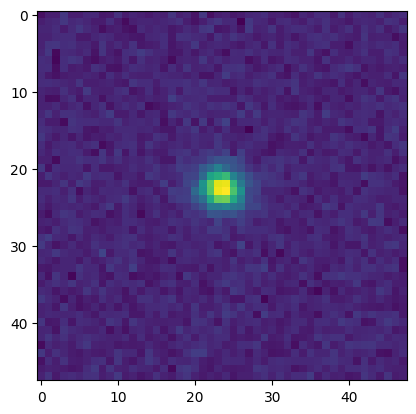

In [30]:
img_no = 2
galim = cv2.imread("galaxy_postage/training/mdm_galaxy_training_1.png", cv2.IMREAD_GRAYSCALE)
starim = cv2.imread("star_postage/training/mdm_star_training_1.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(galim)
plt.imshow(starim)

(0.15194451300899436, 0.1668375538533896)

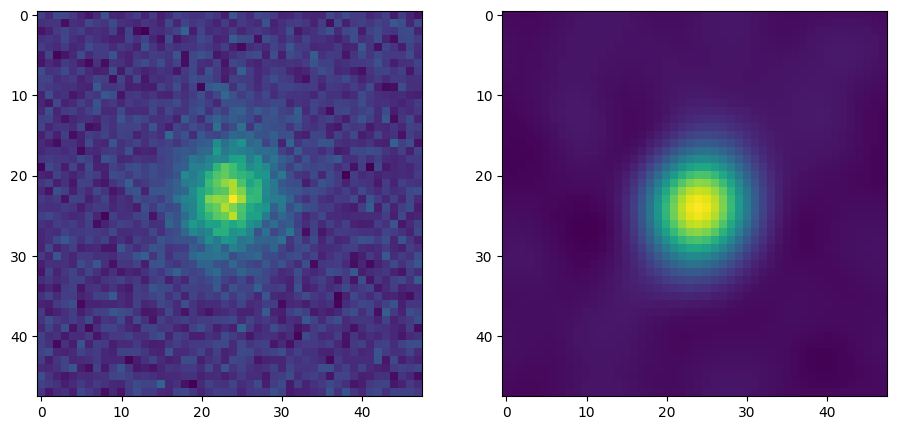

In [9]:
img_no = 1
galim = cv2.imread(f"galaxy_postage/training/mdm_galaxy_training_{img_no}.png", cv2.IMREAD_GRAYSCALE)
starim = cv2.imread(f"star_postage/training/mdm_star_training_{img_no}.png", cv2.IMREAD_GRAYSCALE)

from skimage import color, data, restoration
img = galim.astype(np.float_)
from scipy.signal import convolve2d
psf = starim.astype(np.float_)
# img = convolve2d(img, psf, 'same')
# rng = np.random.default_rng()
# img += 0.1 * img.std() * rng.standard_normal(img.shape)
deconvolved_img = restoration.wiener(img, psf, 99999999)

fig, axes = plt.subplots(1,2, figsize=(11,5))
axes[0].imshow(img)
axes[1].imshow(deconvolved_img)
getUWQM(deconvolved_img)

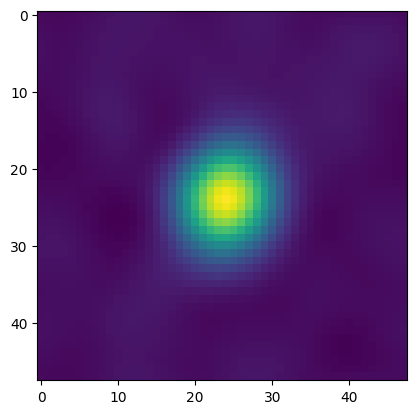

In [10]:
from numpy import fft
from scipy.signal import convolve2d

def getDeconvolvedImg(img, kernel, balance=99999999):
    float_img = img.astype(np.float_)
    psf = kernel.astype(np.float_)
    deconvolved_img = restoration.wiener(img, psf, balance)
    min_im = deconvolved_img.min()
    max_im = deconvolved_img.max()
    deconvolved_img = (deconvolved_img - min_im) / (max_im - min_im)
    return deconvolved_img

plt.imshow(getDeconvolvedImg(galim, starim, 99999999))

In [11]:
galaxy_convolved_imgs = np.zeros((40000, 48, 48, 1))

for i in range(1, 40001):
    image_path = f"galaxy_postage/training/mdm_galaxy_training_{i}.png"
    galim = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_path = f"star_postage/training/mdm_star_training_{i}.png"
    starim = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # im = ndi.gaussian_filter(im, sigma=0.5) # denoise
    im = getDeconvolvedImg(galim, starim)
    min_im = im.min()
    max_im = im.max()
    im = (im - min_im) / (max_im - min_im)
    galaxy_convolved_imgs[i-1] = im.reshape((48,48,1))
    if i % 10 == 0:
        print(f"{i} done!",end="\r")

In [45]:
val_galaxy_convolved_imgs = np.zeros((30000, 48, 48, 1))
test_galaxy_convolved_imgs = np.zeros((30000, 48, 48, 1))

for i in range(1, 60001):
    image_path = f"galaxy_postage/test/mdm_galaxy_test_{i}.png"
    galim = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_path = f"star_postage/test/mdm_star_test_{i}.png"
    starim = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # im = ndi.gaussian_filter(im, sigma=0.5) # denoise
    im = getDeconvolvedImg(galim, starim)
    min_im = im.min()
    max_im = im.max()
    im = (im - min_im) / (max_im - min_im)
    if i <= 30_000:
        val_galaxy_convolved_imgs[i-1] = im.reshape((48,48,1))
    else:
        test_galaxy_convolved_imgs[i-30_001] = im.reshape((48,48,1))
    if i % 10 == 0:
        print(f"{i} done!",end="\r")

In [65]:
model = keras.Sequential()

model.add(layers.Conv2D(20, (12,12), input_shape=(48,48,1), activation="relu"))
model.add(layers.Conv2D(20, (8,8), activation="relu"))
model.add(layers.Conv2D(20, (4,4), activation="relu"))
model.add(layers.Conv2D(20, (4,4), activation="relu"))
model.add(layers.Conv2D(10, (4,4), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dense(30, activation="relu"))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(2, activation="linear"))

mse = tf.keras.losses.MeanSquaredError()
model.compile(
    loss=mse, 
    optimizer='adam'
)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 37, 37, 20)        2900      
                                                                 
 conv2d_39 (Conv2D)          (None, 30, 30, 20)        25620     
                                                                 
 conv2d_40 (Conv2D)          (None, 27, 27, 20)        6420      
                                                                 
 conv2d_41 (Conv2D)          (None, 24, 24, 20)        6420      
                                                                 
 conv2d_42 (Conv2D)          (None, 21, 21, 10)        3210      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 10)       0         
 g2D)                                                            
                                                     

Epoch 1/10
400/400 [==============================] - 27s 65ms/step - loss: 0.0030 - val_loss: 8.3765e-04
Epoch 2/10
400/400 [==============================] - 27s 67ms/step - loss: 5.9001e-04 - val_loss: 6.2502e-04
Epoch 3/10
400/400 [==============================] - 28s 69ms/step - loss: 5.5981e-04 - val_loss: 8.2323e-04
Epoch 4/10
400/400 [==============================] - 28s 69ms/step - loss: 5.4283e-04 - val_loss: 7.2707e-04
Epoch 5/10
400/400 [==============================] - 28s 69ms/step - loss: 5.3994e-04 - val_loss: 8.4405e-04
Epoch 6/10
400/400 [==============================] - 28s 69ms/step - loss: 5.2223e-04 - val_loss: 8.3593e-04
Epoch 7/10
400/400 [==============================] - 28s 69ms/step - loss: 5.2468e-04 - val_loss: 5.5669e-04
Epoch 8/10
400/400 [==============================] - 28s 70ms/step - loss: 5.3987e-04 - val_loss: 5.6083e-04
Epoch 9/10
400/400 [==============================] - 28s 70ms/step - loss: 5.0233e-04 - val_loss: 6.0624e-04
Epoch 10/10
40

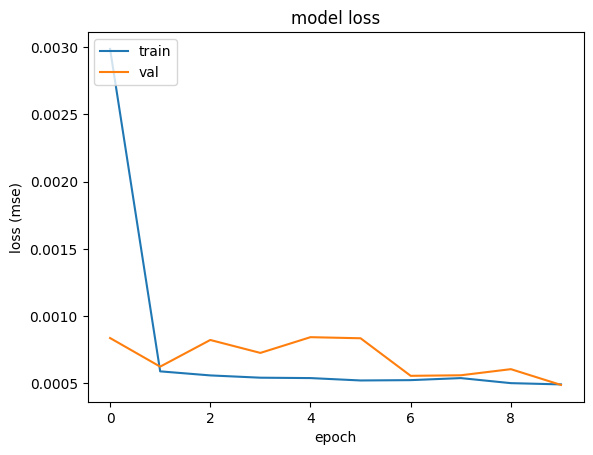

In [66]:
history = model.fit(galaxy_convolved_imgs, train_es, validation_data=[val_galaxy_convolved_imgs, test_es[:30_000]], batch_size=100, epochs=10)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss (mse)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [67]:
rms_e1 = 0
rms_e2 = 0
es = model.predict(test_galaxy_convolved_imgs, batch_size=100)
for i in range(0, 30000):
    rms_e1 += sqerr(te1s[i+30_000], es[i][0])
    rms_e2 += sqerr(te2s[i+30_000], es[i][1])
    if (i + 1) % 10 == 0:
        print(f"{i+1} done!",end="\r")
    
rms_e1 /= e1s.shape[0]
rms_e2 /= e2s.shape[0]

rms_e1 = np.sqrt(rms_e1)
rms_e2 = np.sqrt(rms_e2)

print()
print(rms_e1)
print(rms_e2)

300/300 [==============================] - 6s 18ms/step
30000 done!
0.019554227246177384
0.01865979140247788


In [68]:
es = model.predict(galaxy_convolved_imgs[:5], batch_size=100)
es

1/1 [==============================] - 0s 53ms/step


array([[-0.09875698,  0.08273844],
       [ 0.08923342,  0.06984186],
       [ 0.06968107, -0.15712127],
       [-0.18229693, -0.01957068],
       [-0.04330627, -0.3039862 ]], dtype=float32)

## UWQM on deconvolved image

In [69]:
mse_e1 = 0
mse_e2 = 0

def abserr(value, truth):
    return np.abs(value - truth)

def sqerr(value, truth):
    return (value - truth) * (value - truth)

for i in range(1, 40001):
    im = galaxy_convolved_imgs[i-1].reshape((48,48))
    es = getUWQM(im)
    mse_e1 += abserr(e1s[i-1], es[0])
    mse_e2 += abserr(e2s[i-1], es[1])
    if i % 10 == 0:
        print(f"{i} done!",end="\r")
    
mse_e1 /= e1s.shape[0]
mse_e2 /= e2s.shape[0]

mse_e1 = np.sqrt(mse_e1)
mse_e2 = np.sqrt(mse_e2)

print()
print(mse_e1)
print(mse_e2)

40000 done!
0.31603086744955766
0.3901479609926266
